## CommonCrawl

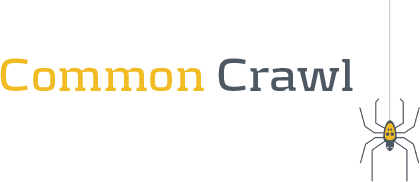

CommonCrawl is a publically accessible web crawl.

It comprises ca. 250TB and 3 billion web pages, hosted on AWS S3 as a public dataset.

Pageranks for 112m domains are available, as well as a [host-level webgraph](http://commoncrawl.org/2017/05/hostgraph-2017-feb-mar-apr-crawls/)

In [1]:
import re

RE_MAPS = re.compile(r'(https?://(?:(?:www\.)?google\.[^/]*/maps|maps\.google\.[^/]*|maps\.googleapis\.[^/]*)[^ <>"]*)')
RE_EXCLUSION = re.compile(r'geocode/json\?|api/js\?')

def find_google_maps(unibody):
    """ find google maps links in the page HTML """
    for match in set(RE_MAPS.findall(unibody)):
        if not RE_EXCLUSION.search(match):
            yield match            

In [2]:
from itertools import islice
import json

from warcio.archiveiterator import ArchiveIterator
import smart_open 
from tqdm import tqdm_notebook
import pandas as pd
from  w3lib.encoding import html_to_unicode

from html_to_etree import parse_html_bytes
from extract_social_media import find_links_tree


def process(url):
    """
    extract html responses from commoncrawl and extract social media links
    """
    warc_input = smart_open.smart_open(url) 

    records = ArchiveIterator(warc_input, arc2warc=True)
    for record in records: 
        if record.rec_type == 'response':
            content_type = record.http_headers.get_header('Content-Type')
            if 'text/html' not in content_type:
                continue
                
            uri = record.rec_headers.get_header('WARC-Target-URI')
            body = record.content_stream().read()
            
            unibody = html_to_unicode(content_type, body, default_encoding='utf8')[1]

            tree = parse_html_bytes(body, content_type)
            links = [x for x in set(find_links_tree(tree))
                     if x and len(x) < 100]
            yield {
                'uri': uri,
                'social_media': links,
                'google_maps': list(find_google_maps(unibody))
            }

In [4]:
SAMPLE_URL = 's3://commoncrawl/crawl-data/CC-NEWS/2018/04/CC-NEWS-20180405091124-00174.warc.gz'
recs = process(SAMPLE_URL)
recs = list(islice(tqdm_notebook(recs), 3000))

In [11]:
with_maps = [r for r in recs if r['google_maps']]
print(json.dumps(with_maps, indent=4))
# pd.DataFrame(with_maps)

[
    {
        "uri": "http://www.oregonwinepress.com/event-detail?eventTitle=the-brothers-reed-at-south-stage-cellars--1523430000--21952",
        "social_media": [
            "https://www.facebook.com/pages/Oregon-Wine-Press/56204313628",
            "https://twitter.com/oregonwinepress",
            "https://www.instagram.com/oregonwinepress/"
        ],
        "google_maps": [
            "http://maps.google.com/maps?q=125",
            "http://maps.google.com/maps?f=q&#38;source=s_q&#38;hl=en&#38;geocode=&#38;iwloc=&#38;q=125+S+3rd+Street,+Jacksonville,+OR,+97530,+United+States,&#38;ie=UTF8&#38;hq=&#38;hnear=125+S+3rd+Street,+Jacksonville,+OR,+97530,+United+States,&#38;z=14&#38;output=embed"
        ]
    },
    {
        "uri": "https://www.webnewswire.com/2018/04/05/rea-associates-announces-its-new-website/",
        "social_media": [],
        "google_maps": [
            "https://www.google.com/maps/place/Rea+%26+Associates/@41.67462,-81.3413647,17z/data=!3m1!4b1!4m5!3m4!1s

### Scaling

We can easily run code like the above on AWS Lambda against the S3 data, to scale and speed up the process.
The cost for processing a significant chunk of CommonCrawl data can be quite manageable, especially if we aggressively filter for pages of relevance and make sure that our libraries are not too slow per page.

[pywren AWS Lambda example](https://github.com/aws-samples/pywren-workshops/blob/master/Lab-2-Common-Crawl/web_search.ipynb)